# LAB 03 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

### Imports of libraries and packages

In [1]:
import numpy as np
import numpy.typing as npt
import open_atmos_jupyter_utils
from matplotlib import pyplot

pyplot.rcParams['axes.grid'] = True

### Problem definition

The goal of the analysis is to check how the upwind scheme algorithm error rate converges with changing resolution $\Delta t$ (temporal step, convergence in time) or $\Delta x$ (spatial convergence, convergence in space). In other words, what (or how big) benefits (reduced error rate) do we get if we change the resolution of the algorithm. Changing the resolution is important because having higher resolution is both the memory and compute time investment.

To test the upwind algorithm, I will use the analytical solution of the advection partial differential equation as a ground truth for the numerical solution (computed with upwind). This is to then measure the error rate using RMSE (Root Mean Square Error).


### Advection partial differential equation

The partial differential equation of the advection with additional assumptions and the following boundary and initial conditions:

$$
\frac{\partial \psi}{\partial t} + \frac{\partial (u\psi)}{\partial x} = 0
$$

##### Additional assumptions:

The change of $u$ in the space coordinate ($x$) is $0$.

$$
\frac{\partial u}{\partial x} = 0
$$

##### Boundary and Initial conditions:

$$
\psi(x, 0) = \psi_0(x) = ae^{\frac{-(x - x_0)^2}{2 \sigma^2}}
$$

where,

- $a$ — is some scaling factor.
- $x_0$ — is the shift (mean) of the normal distribution.
- $\sigma$ — is the variance of the normal distribution.
- $\psi(x, 0)$ — is the value of a function $\psi$ at the $t=0$. It notes the initial value of a signal that will be under the influence of partial differential equation.


### Analytic Solution

An analytic solution to the first differential equation given the boundary and initial conditions listed above:

1. Notice that because of our assumption: $\frac{\partial u}{\partial x} = 0$ and the following derivative property: $(af)'(x) = af'(x)$ can simplify the equation to:

    $$
    \frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} = 0
    $$

2. Notice that the differential equation above is a "transport equation" as described below:

    $$
    a\frac{\partial}{\partial x}\psi(x, t) + b \frac{\partial}{\partial t}\psi(x, t) = 0
    $$

    - where:

        - $a = u$ ; $a$ is near the $x$ argument in $\psi(x, t)$,
        - $b = 1$ ; $b$ is near the $t$ argument in $\psi(x, t)$.

3. Because this is a transport equation, we can "guess" the $\psi(x, t)$ using the characteristic linear curve ($ay - bx = C$) and get:

    $$
    \psi(x, t) = f(C) = f(ay - bx) = f(ut - x)
    $$

    - where:

        -   $f$ is some function.

4. After taking into consideration our initial conditions, we can find the function $f$:

    $$
    \psi(x, 0) = f(-x) = ae^{\frac{-(x - x_0)^2}{2 \sigma^2}}
    $$

    $$
    \implies f(x) = ae^{\frac{-(-x - x_0)^2}{2 \sigma^2}}
    $$

5. Therefore, the analytic solution is as follows:

    $$
    \psi(x, t) = f(ut - x) = ae^{\frac{-(-(ut - x) - x_0)^2}{2 \sigma^2}} = ae^{\frac{-((x - ut) - x_0)^2}{2 \sigma^2}} =\psi_0(x - ut)
    $$

The code below implements the $\psi_0$ and the $\psi$ functions.


In [2]:
from collections.abc import Callable

def create_psi_0(x0: np.number, a: np.number, sigma: np.number) -> Callable[[npt.NDArray], npt.NDArray]:
    """Simple curring wrapper to add permanent state to a psi_0(x) function"""

    def psi_0(x: npt.NDArray) -> npt.NDArray:
        """Implementation of a psi_0(x) just like in the laboratory classes"""

        nonlocal x0
        nonlocal a
        nonlocal sigma

        return a * np.exp(-(x - x0) ** 2 / 2 / sigma ** 2)

    return psi_0

In [3]:
def create_analytical_solution(psi_0: Callable[[npt.NDArray], npt.NDArray], u: np.number) -> Callable[[npt.NDArray, np.number], npt.NDArray]:
    """Simple curring wrapper to add permanent state to a psi(x, t) function"""

    def psi(x: npt.NDArray, t: np.number) -> npt.NDArray:
        """Implementation of a psi(x, t) just like in the laboratory classes"""

        nonlocal psi_0
        nonlocal u

        return psi_0(x - u * t)

    return psi

### Numerical Solution

Numerical solution is implemented using upwind solver just as described in the laboratory classes.

The only difference between here and laboratory classes notebook is that the algorithm is parametrised and implemented as a Python function ***upwind_solver(...)***.

In [4]:
def F(first, second, courant):
    return .5 * (courant + abs(courant)) * first + \
        .5 * (courant - abs(courant)) * second

class One:
    def __rsub__(self, other: slice) -> slice:
        assert isinstance(other, slice), f'Unsupported type {type(other)}'
        assert other.start > 0, f'Unsupported step {other.step}'

        return slice(other.start - 1, other.stop - 1, other.step)

    def __radd__(self, other: slice) -> slice:
        assert isinstance(other, slice), f'Unsupported type {type(other)}'

        return slice(other.start + 1, other.stop + 1, other.step)

In [5]:
def upwind_solver(psi_0: Callable[[npt.NDArray], npt.NDArray], x: npt.NDArray, nx: int, nt: int, c: float):
    """.Implementation of the upwind solver just as in the laboratory classes"""

    assert nx > 2, f'The number of x points ({nx=}) must be grater than two'
    assert nt > 0, f'The number of t points ({nt=}) must be grater than zero'

    i = slice(1, nx - 1)
    one = One()
    psi = psi_0(x)

    for _ in range(nt):
        psi[i] = psi[i] - (F(psi[i], psi[i + one], c) - F(psi[i - one], psi[i], c))

    return psi

### RMSE - Root Mean Square Error

Root Mean Square Error is a measure of error between two vectors ($x^{pred}$ (the predicted vector) and $x^{true}$ (the actual vector)) of size $N$ as shown below:

$$
RMSE(x^{pred}, x^{true}) = \sqrt\frac{\sum_{i=1}^N (x^{pred}_i - x^{true}_i)^2}{N}
$$

where,

- $x^{pred}$ — The approximated solution (predicted using numerical methods) ($x^{pred}_i$ — the $i$ element of the vector $x^{pred}$),
- $x^{true}$ — The vector denoting analytical (actual) solution results ($x^{true}_i$ — the $i$ element of the vector $x^{true}$),
- $N$ — The total number of elements in vectors.


The function from above can be implemented as a Python function over vectors just like shown below:

In [6]:
def root_mean_square_error[S: tuple[int, ...], T: npt.DTypeLike](x_pred: np.ndarray[S, np.dtype[T]], x_true: np.ndarray[S, np.dtype[T]]) -> np.number[T]:
    """Numpy implementation of a RMSE (Root Mean Square Error)"""

    assert x_pred.shape == x_true.shape, f'{x_pred.shape=} != {x_true.shape=}, The input vectors have different shapes'

    return np.sqrt(np.mean((x_pred - x_true) ** 2))

### Comparison of error as a function of the resolution

##### Initial values for the analysis

All computations will be performed up to np.float64 machine precision.

Parameters:

- The $\psi_0$ parameters will be the same as in the laboratory classes.
- $u$ will be 10 times bigger (explained below).
- The $x$ range will be expanded by $100$ unit to the right.
- The $t$ is the same as before.
- There will be $50$ tests. Each will use different number of both space (nx) and time (nt) grid cells. The nx & nt will be taken from the range of $225$ to $100,000$ each as a np.uint32.

In [7]:
from typing import Final

X0: Final = np.float64(5)
A: Final = np.float64(1)
SIGMA: Final = np.float64(25)

In [8]:
PSI_0: Final = create_psi_0(X0, A, SIGMA)

In [9]:
U: Final = np.float64(5)

In [10]:
PSI_ANALYTICAL: Final = create_analytical_solution(PSI_0, U)

In [11]:
X_START: Final = np.float64(-100)
X_END: Final = np.float64(400)

In [12]:
T: Final = np.float64(50)

In [13]:
TEST_NUMBER: Final = 50

In [14]:
NX_START: Final = np.float64(np.log10(225))
NX_END: Final = np.float64(np.log10(100_000))

In [15]:
NT_START: Final = np.float64(np.log10(225))
NT_END: Final = np.float64(np.log10(100_000))

##### Courant number

Courant number will be constant for every set of $\Delta x$ & $\Delta t$ used in this notebook. This behaviour is guaranteed by the assert statement in the function below.

The definition of the Courant number is as follows:

$$
C = \frac{u \Delta t}{\Delta x}
$$

As we can deduce in order for the RHS to stay constant, the $\frac{\Delta t}{\Delta x}$ must stay constant.

I have chosen the numerical values so that the $\frac{\Delta t}{\Delta x} = 0.1$ and $u = 5$ so in the result we have $C=\frac{1}{2}$. The $C=\frac{1}{2}$ is used as advised in the laboratory classes.

The $\Delta x$ & $\Delta t$ are both directly influenced by nx and nt respectively.

### The convergence analysis of the upwind sheme

In [16]:
def create_convergence_analysis(nx_nt_values: list[tuple[int, int]]) -> tuple[npt.NDArray, npt.NDArray, npt.NDArray]:
    """Function that creates the upwind sheme algorithm convergence rate"""

    errors = np.zeros(shape=(len(nx_nt_values),), dtype=np.float64)
    dxs = np.zeros(shape=(len(nx_nt_values),), dtype=np.float64)
    dts = np.zeros(shape=(len(nx_nt_values),), dtype=np.float64)

    for index, (nx, nt) in enumerate(nx_nt_values):
        x, dx = np.linspace(X_START, X_END, nx, endpoint=False, retstep=True, dtype=np.float64)
        dt = T / nt

        c = U * dt / dx
        assert np.isclose(c, 0.5), f'{c=} should be around 0.5'

        analytical = PSI_ANALYTICAL(x, T)
        numerical = upwind_solver(PSI_0, x, nx, nt, c)

        error = root_mean_square_error(numerical, analytical)

        errors[index] = error
        dxs[index] = dx
        dts[index] = dt

    return errors, dxs, dts


In [17]:
def create_plot(errors, dxs, dts) -> None:
    """Function that displays the convergence graph"""

    fig = pyplot.figure(figsize=(12, 12))
    fig.suptitle('The Error Convergence graph for Upwind scheme algorithm with respect to changes in dx or dt', weight='bold', size='x-large')

    (ax1, ax2), (ax3, ax4) = fig.subplots(2, 2, sharex='col')

    ax1.set_title('RMSE vs dx on logarithmic axes')
    ax1.set_xlabel(f'dx')
    ax1.set_ylabel(f'Root Mean Square Error')
    ax1.tick_params(labelbottom=True)

    ax2.set_title('RMSE vs dx')
    ax2.set_xlabel(f'dx')
    ax2.set_ylabel(f'Root Mean Square Error')
    ax2.tick_params(labelbottom=True)

    ax3.set_title('RMSE vs dt on logarithmic axes')
    ax3.set_xlabel(f'dt')
    ax3.set_ylabel(f'Root Mean Square Error')

    ax4.set_title('RMSE vs dt')
    ax4.set_xlabel(f'dt')
    ax4.set_ylabel(f'Root Mean Square Error')

    coefficients_dx = np.polyfit(dxs, errors, deg=1)
    dxs2 = np.logspace(np.log10(dxs.min()), np.log10(dxs.max()), num=len(dxs))
    poly_fn_dx = np.poly1d(coefficients_dx)

    coefficients_dt = np.polyfit(dts, errors, deg=1)
    dts2 = np.logspace(np.log10(dts.min()), np.log10(dts.max()), num=len(dts))
    poly_fn_dt = np.poly1d(coefficients_dt)

    ax1.loglog(dxs, errors, 'ro', label='RMSE'); ax1.loglog(dxs2, poly_fn_dx(dxs2), '--k', label=f'Linear Reg: {coefficients_dx}')
    ax2.plot(dxs, errors, 'ro', label='RMSE'); ax2.plot(dxs, poly_fn_dx(dxs), '--k', label=f'Linear Reg: {coefficients_dx}')
    ax3.loglog(dts, errors, 'bo', label='RMSE'); ax3.loglog(dts2, poly_fn_dt(dts2), '--k', label=f'Linear Reg:{coefficients_dt}')
    ax4.plot(dts, errors, 'bo', label='RMSE'); ax4.plot(dts, poly_fn_dt(dts), '--k', label=f'Linear Reg:{coefficients_dt}')

    ax1.legend(loc='lower right', prop={'size': 9})
    ax2.legend(loc='lower right', prop={'size': 9})
    ax3.legend(loc='lower right', prop={'size': 9})
    ax4.legend(loc='lower right', prop={'size': 9})

    fig.tight_layout()

    open_atmos_jupyter_utils.show_plot(fig=fig)

In [18]:
NX_NT_VALUES: Final = np.repeat(np.expand_dims(np.logspace(NX_START, NX_END, num=TEST_NUMBER, dtype=np.uint32, endpoint=False), axis=-1), repeats=2, axis=1)

In [19]:
ERRORS, DXS, DTS = create_convergence_analysis(NX_NT_VALUES)

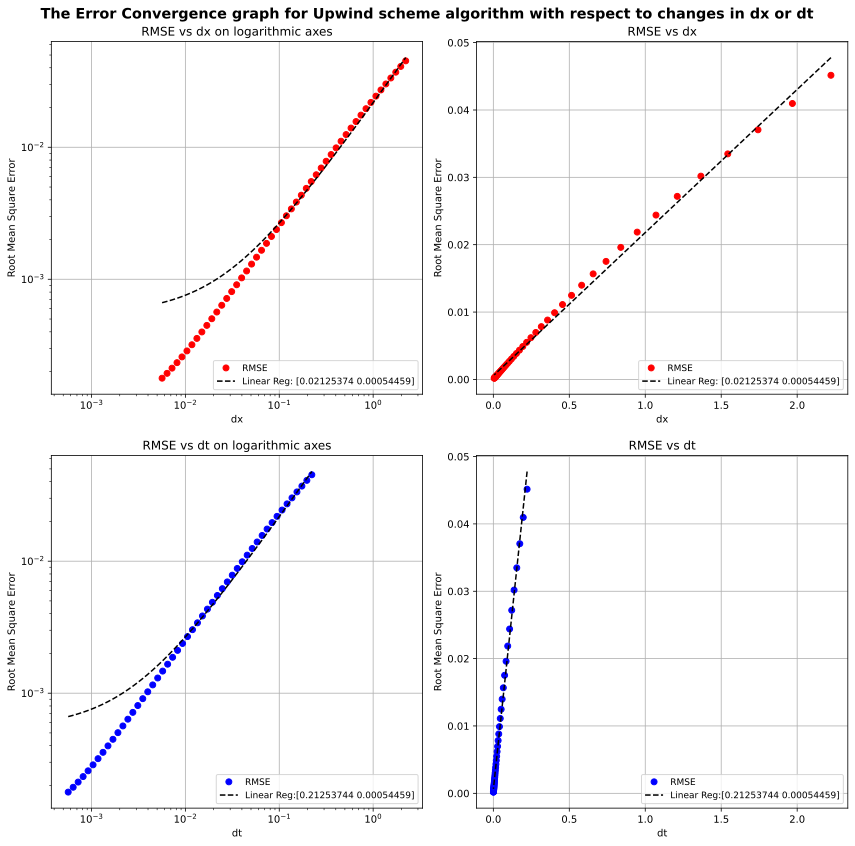

In [20]:
create_plot(ERRORS, DXS, DTS)

### Conclusions:

After I have generated the plot, I can conclude the following:

- The value of error grows linearly with regard to the change of the resolution. It can be concluded by consulting the data dots (red and blue) with the linear regression curve (degree = 1) (black dashed). This means that if we want to achieve twice as accurate numerical approximations, compared to analytical solutions, we will need twice as bigger resolution of time and space (i.e. twice as many grid cells in time and space).

- We can notice that on the logarithmic scale, the line of best fit diverges around the small values of the resolution ($\Delta x$ & $\Delta t$). However, this fact can be understood because on the logarithmic scale, the tiny imperfections in the linear curve are very visually highlighted. The predicted error by linear regression line is in the same magnitude $10^{-3}$ as the actual value of error in the range of the smallest values of $\Delta x$ & $\Delta t$.